# Face Recognition Project - Gender Classification Using Resnet

Pada projek ini, data yang dipakai berasal dari celeba: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from skimage import io
import random
from torchvision.models import ResNet18_Weights
plt.ion()

In [ ]:
!pip install gdown

Download terlebih dahulu file zip nya.

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1fZOcwUtZfbPdDAX9uFxdRtS1n1QrU6LA&export=download

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1fZOcwUtZfbPdDAX9uFxdRtS1n1QrU6LA
From (redirected): https://drive.google.com/uc?id=1fZOcwUtZfbPdDAX9uFxdRtS1n1QrU6LA&confirm=t&uuid=ca70f2f3-504f-443c-adda-6ff3f12d2db5
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:31<00:00, 46.4MB/s]


Kemudian kita unzip sehingga masuk ke folder di google colab.

In [ ]:
!unzip img_align_celeba.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

Lalu, kita download data attribut dan data train test split.

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1YCXuzDu4MvBoqzv6lzNhAjm6T9P-ezDW&export=download

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1YCXuzDu4MvBoqzv6lzNhAjm6T9P-ezDW
From (redirected): https://drive.google.com/uc?id=1YCXuzDu4MvBoqzv6lzNhAjm6T9P-ezDW&confirm=t&uuid=4b8e781b-e33b-4782-b101-03bcb1d25af8
To: /content/list_attr_celeba.txt
100% 26.7M/26.7M [00:00<00:00, 36.3MB/s]


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1ec3vm06TS8JUd1utUSVpOHZpuAIwE-BK&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1ec3vm06TS8JUd1utUSVpOHZpuAIwE-BK
To: /content/list_eval_partition.txt
100% 2.84M/2.84M [00:00<00:00, 167MB/s]


## Data Preprocessing dan Train Test Split

Kita baca dahulu file attribut, kemudian kita ekstrak value dari setiap row nya. Terdapat 40 attribut dan kita hanya ambil kolom male yaitu kolom no ke 21 dimana -1 berarti female dan 1 berarti male. Kita explore dahulu cara akses attribut.

In [ ]:
attributes_txt = open('list_attr_celeba.txt')
attributes = attributes_txt.readlines()

In [ ]:
attr = attributes[2].split('jpg')[1].split('\n')[0].split(' ')
attr = [int(x) for x in attr if x != '']
attr

[-1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1]

In [ ]:
len(attr)

40

In [ ]:
cek = attributes[2].split()
print(len(cek))
print(cek)

41
['000001.jpg', '-1', '1', '1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '1', '-1', '-1', '-1', '-1', '-1', '-1', '1', '1', '-1', '1', '-1', '-1', '1', '-1', '-1', '1', '-1', '-1', '-1', '1', '1', '-1', '1', '-1', '1', '-1', '-1', '1']


Kita akses dahulu semua gambar dengan cara membuat folder all_images pada folder img_allign_celeba yang kemudian kita pindah semua images ke folder baru tersebut.

In [ ]:
!mkdir -p ./img_align_celeba/all_images/
!find ./img_align_celeba/ -maxdepth 1 -name "*.jpg" -print0 | xargs -0 mv -t ./img_align_celeba/all_images/

Sekarang kita explore cara ambil nama file dari gambar dan lokasinya.

In [ ]:
all_dataset = datasets.ImageFolder('img_align_celeba')

In [ ]:
len(all_dataset)

202599

In [ ]:
print(all_dataset.imgs[0][0])
print(all_dataset.imgs[0][0].split('/'))
print(all_dataset.imgs[0][0].split('/')[2])

img_align_celeba/all_images/000001.jpg
['img_align_celeba', 'all_images', '000001.jpg']
000001.jpg


Kita explore cara akses kode train test split, dimana 0 berarti data train, 1 berarti data val, dan 2 berarti data test.

In [ ]:
split_txt = open('list_eval_partition.txt')
split_data = split_txt.readlines()

In [ ]:
split_code = int(split_data[0].split(' ')[1].split('\n')[0])
split_code

0

Buat direktori train, val, test yang berisi male dan female images.

In [ ]:
!mkdir train
!mkdir train/male
!mkdir train/female

In [ ]:
!mkdir val
!mkdir val/male
!mkdir val/female

In [ ]:
!mkdir test
!mkdir test/male
!mkdir test/female

In [ ]:
for j in range(len(all_dataset)):
  # data atribut dari image
  attr = attributes[2+j].split('jpg')[1].split('\n')[0].split(' ')
  attr = [int(x) for x in attr if x != '']

  # mencari image dan lokasinya
  path = all_dataset.imgs[j][0]
  img = io.imread(path)
  img_name = all_dataset.imgs[j][0].split('/')[2]

  # mencari code split
  split_code = int(split_data[j].split(' ')[1].split('\n')[0])

  # pindah image ke folder train val test dan gender yang sesuai
  if attr[20] == 1:
    if split_code == 0:
      io.imsave('./train/male/'+img_name,img)
    elif split_code == 1:
      io.imsave('./val/male/'+img_name,img)
    elif split_code == 2:
      io.imsave('./test/male/'+img_name,img)
  else:
    if split_code == 0:
      io.imsave('./train/female/'+img_name,img)
    elif split_code == 1:
      io.imsave('./val/female/'+img_name,img)
    elif split_code == 2:
      io.imsave('./test/female/'+img_name,img)

  os.remove(path) # menghapus file yang sudah dipindahkan

## Learning Part

Kita transform dahulu data image nya kemudian masukkan ke dalam data loader.

In [ ]:
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
'''

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet butuh input 224x224
    transforms.ToTensor(),          # Mengubah gambar ke Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisasi dengan mean dan std ImageNet
])

data_dir = '.'
# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) for x in ['train', 'val', 'test']}

# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [ ]:
print(dataset_sizes)

{'train': 162770, 'val': 19867, 'test': 19962}


In [ ]:
print(class_names)

['female', 'male']




```
# This is formatted as code
```

Kita coba tampilkan ulang gambar yang sudah ditransform.

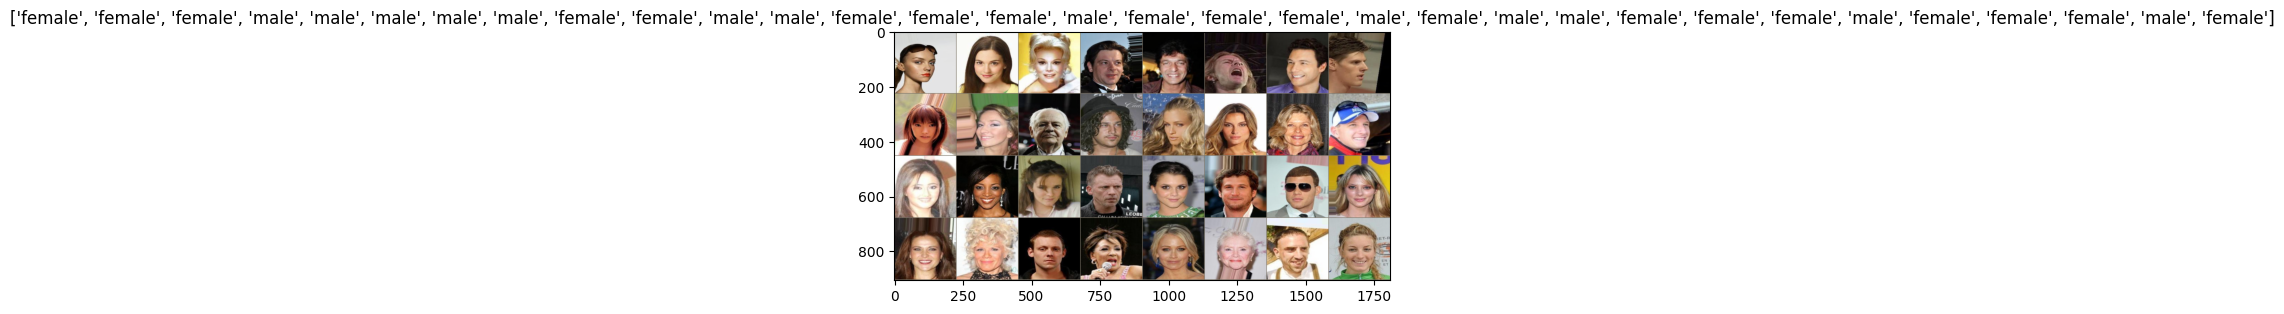

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Kemudian kita buat folder gender untuk menampung model yang sudah dibuat.

In [ ]:
!mkdir gender

Membut sebuah fungsi train yang digunakan untuk melatih model beserta mengevaluasinya dengan menggunakan data test di setiap Epoch. Ketika data sedang dievaluasi, tidak perlu ada proses backward propagation. Apabila menggunakan google colab, jangan lupa untuk cek penggunaan GPU. Caranya, klik menu Runtime di atas, kemudian klik Change runtime type, pilih GPU dan save.

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                # inputs berupa batch sehingga ada sebanyak batch baris data beserta labelnya
                # contoh: jika batch=8 berarti ada 8 images pada inputs beserta labelnya
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                # angka 1 di torch.max berarti mengambil data prob maks dari setiap baris (image) untuk mendapatkan label yang prob nya tinggi
                # hasil berupa _=nilai maksimum dan preds=indeks/label
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./gender/point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Kita buat fungsi visualize model untuk memvisualisasi hasil model yang kita buat ke data test.

In [ ]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()


    for i, data in enumerate(dataloders['test']):
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Sekarang, kita buat model yang diinginkan beserta loss function dan optimizernya.

In [ ]:
# Load ResNet-18 pre-trained model
# model_ft = models.resnet18(pretrained=True) -> ini adalah cara lama memanggil pretrained, cara terbaru pakai weight (recommended)
# jangan lupa import -> from torchvision.models import ResNet18_Weights
model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Ganti fully connected layer terakhir untuk 2 kelas (male/female)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # Output untuk 2 kelas

# GPU
if use_gpu:
    model_ft = model_ft.cuda()

# Loss function
criterion = nn.CrossEntropyLoss()

# Mengatur optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

Lalu, kita implementasikan ke fungsi train_model.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0018 Acc: 0.9791
val Loss: 0.0015 Acc: 0.9842

Epoch 1/9
----------
train Loss: 0.0011 Acc: 0.9882
val Loss: 0.0011 Acc: 0.9880

Epoch 2/9
----------
train Loss: 0.0007 Acc: 0.9922
val Loss: 0.0013 Acc: 0.9852

Epoch 3/9
----------
train Loss: 0.0005 Acc: 0.9950
val Loss: 0.0013 Acc: 0.9873

Epoch 4/9
----------
train Loss: 0.0003 Acc: 0.9960
val Loss: 0.0013 Acc: 0.9882

Epoch 5/9
----------
train Loss: 0.0003 Acc: 0.9968
val Loss: 0.0016 Acc: 0.9870

Epoch 6/9
----------
train Loss: 0.0002 Acc: 0.9974
val Loss: 0.0013 Acc: 0.9892

Epoch 7/9
----------
train Loss: 0.0002 Acc: 0.9976
val Loss: 0.0015 Acc: 0.9876

Epoch 8/9
----------
train Loss: 0.0002 Acc: 0.9980
val Loss: 0.0013 Acc: 0.9878

Epoch 9/9
----------
train Loss: 0.0002 Acc: 0.9982
val Loss: 0.0019 Acc: 0.9848

Training complete in 92m 32s
Best test Acc: 0.989178


Terakhir, kita coba cek hasil prediksi model ke data test dan visualisasinya.

In [ ]:
# mencoba akses model yang sudah disimpan
checkpoint = torch.load('./gender/point_resnet_best.pth', weights_only=True)
model_ft.load_state_dict(checkpoint['model'])
model_ft.eval()

correct = 0
total = 0
total_loss = 0.0
total_batches = 0

with torch.no_grad():
    for i, data in enumerate(dataloders['test']):
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        correct += (preds == labels).sum().item() # tambahkan correct
        total += labels.size(0)
        total_loss += loss.item()  # Tambahkan loss batch ke total loss
        total_batches += 1  # Increment jumlah batch

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

average_loss = total_loss / total_batches
print(f"Average Test Loss: {average_loss:.4f}")

Test Accuracy: 98.55%
Average Test Loss: 0.0582


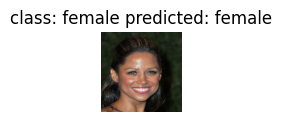

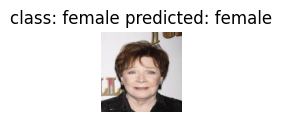

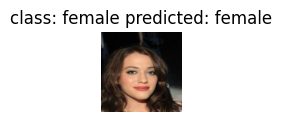

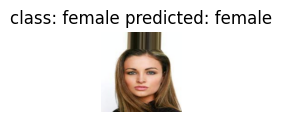

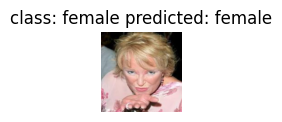

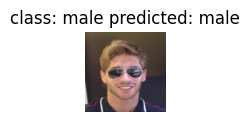

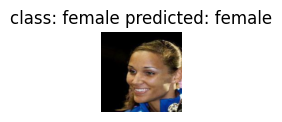

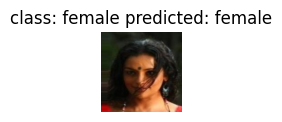

In [ ]:
visualize_model(model_ft, num_images=8)